# Reversible Instance Normalization

In this notebook, we evaluate the performance of Reversible Instance Normalization (RIN) applied to time series data for regression models.

The concept of RIN was introduced for neural network-based time series forecasting in this [paper](https://openreview.net/pdf?id=cGDAkQo1C0p). It has been shown that RIN improves the performance of neural networks in the presence of distribution shifts in time series data.

In this study, we explore whether such normalization procedures can also help improve the performance of regression models for time series forecasting. We will focus on the performance of Linear Regression and LightGBM (random forest model)

In [31]:
# fix python path if working locally
from examples.utils import fix_pythonpath_if_working_locally

fix_pythonpath_if_working_locally()

In [32]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
import contextlib
import os
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

In [34]:
from darts.metrics import mae, mse
from darts.models import LightGBMModel, LinearRegressionModel

### Functions definition

In [35]:
# Test trained models on validation set and plot results
def evaluate_models(models, train_series, val_series):
    """
    Evaluates a set of pre-trained models on given validation time serie, and plots the results and stores the
    error metrics.

    Parameters:
    models (dict): A dictionary where keys are model names and values are pre-trained model instances.
    train_series (TimeSeries or list of TimeSeries): The training time series data.
    val_series (TimeSeries or list of TimeSeries): The validation time series data.

    Returns:
    dict: A dictionary containing the MAE and MSE for each model's predictions.
    """

    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    result_accumulator = {}

    is_list = isinstance(train_series, list)
    if is_list:
        n = len(val_series[0])
    else:
        n = len(val_series)

    for i, (name, model) in enumerate(models.items()):
        pred = model.predict(series=train_series, n=n)

        # Plotting
        if is_list:
            for j in range(len(train_series)):
                if "RINorm" not in name:
                    # train_series[j].plot(ax=axes[i % 2], label="Train")
                    val_series[j].plot(ax=axes[i % 2], label="Valid")
                    pred[j].plot(ax=axes[i % 2], label="Prediction", ls=":")
                else:
                    pred[j].plot(ax=axes[i % 2], label="Prediction RINorm", ls="--")
        else:
            if "RINorm" not in name:
                # train_series.plot(ax=axes[i % 2], label="Train")
                val_series.plot(ax=axes[i % 2], label="Valid")
                pred.plot(ax=axes[i % 2], label="Prediction", ls=":")
            else:
                pred.plot(ax=axes[i % 2], label="Prediction RINorm", ls="--")

        # Calculate and store metrics
        mse_value = mse(val_series, pred)
        mae_value = mae(val_series, pred)

        result_accumulator[name] = {
            "mae": mae_value,
            "mse": mse_value,
        }

        if "RINorm" in name:
            axes[i % 2].set_title(name[:-6])
    axes[1].get_legend().remove()

    return result_accumulator

In [36]:
def backtest_models(models, series, start=0.5, forecast_horizon=5, metric=mae):
    """
    Perform backtesting on a dictionary of models.

    Parameters:
    models (dict): Dictionary containing model names as keys and model instances as values.
    series (TimeSeries): The time series data to be used for backtesting.
    start (float): The starting point for backtesting as a fraction of the series length.
    forecast_horizon (int): The number of time steps to forecast.
    """

    backtest_results = {}

    for name, model in models.items():
        # Perform backtesting
        with contextlib.redirect_stdout(open(os.devnull, "w")):
            backtest_errors = model.backtest(
                series=series,
                start=start,
                metric=metric,
                reduction=None,
                last_points_only=False,
                stride=1,
                forecast_horizon=forecast_horizon,
                verbose=True,
            )
        # Calculate and store MAPE
        backtest_results[name] = backtest_errors

    return backtest_results


def plot_backtest_results(backtest_results):
    """
    Plots the backtest histogram for each model.

    Parameters:
    backtest_results (dict): A dictionary containing the backtest errors for each model.
    """
    plt.figure(figsize=(10, 6))
    for name, errors in backtest_results.items():
        if isinstance(errors, list):
            # Concatenate errors from different series
            errors = np.concatenate(errors)
        print(f"Average MAE: {np.mean(errors):.3f} for {name}")
        plt.hist(
            errors, bins=np.arange(0, min(max(errors), 250), 1), alpha=0.5, label=name
        )
    plt.title("Backtest errors for all models (histogram)")
    plt.xlabel("Error")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

## Linear Time Series

<Axes: xlabel='time'>

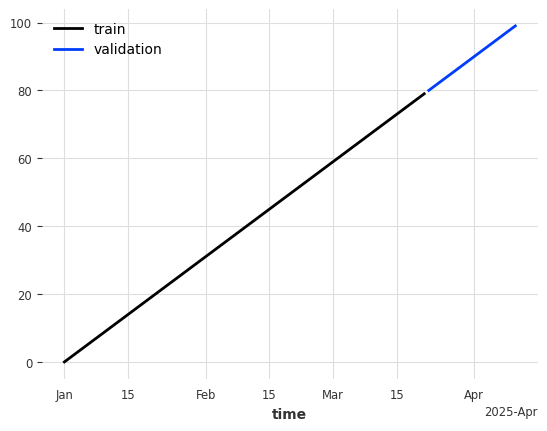

In [37]:
from darts import TimeSeries

# Define the length of the time series
length = 100

# Create a time index
time_index = pd.date_range(start="2025-01-01", periods=length, freq="D")

# Create the time series data
data = np.arange(length)

# Create the TimeSeries object
linear_serie = TimeSeries.from_times_and_values(time_index, data)
linear_train, linear_val = linear_serie.split_after(0.8)

linear_train.plot(label="train")
linear_val.plot(label="validation")

In [38]:
# DEFINE PARAMETERS
LAGS = 20
OUTPUT_CHUNK_LENGTH = 5

# Define models
models_linear = {
    "Linear Regression": LinearRegressionModel(
        lags=LAGS, output_chunk_length=OUTPUT_CHUNK_LENGTH
    ),
    "LightGBM": LightGBMModel(lags=LAGS, output_chunk_length=OUTPUT_CHUNK_LENGTH),
    "Linear Regression RINorm": LinearRegressionModel(
        lags=LAGS,
        output_chunk_length=OUTPUT_CHUNK_LENGTH,
        use_reversible_instance_norm=True,
    ),
    "LightGBM RINorm": LightGBMModel(
        lags=LAGS,
        output_chunk_length=OUTPUT_CHUNK_LENGTH,
        use_reversible_instance_norm=True,
    ),
}

# Fit model to data
for i, (name, model) in enumerate(models_linear.items()):
    if "RINorm" not in name:
        with contextlib.redirect_stdout(open(os.devnull, "w")):
            model.fit(series=linear_train)

        rinorm_model = models_linear[name + " RINorm"]
        with contextlib.redirect_stdout(open(os.devnull, "w")):
            rinorm_model.fit(series=linear_train)

Model: Linear Regression
  MAE: 0.000
  MSE: 0.000

Model: LightGBM
  MAE: 22.020
  MSE: 516.124

Model: Linear Regression RINorm
  MAE: 0.000
  MSE: 0.000

Model: LightGBM RINorm
  MAE: 0.000
  MSE: 0.000



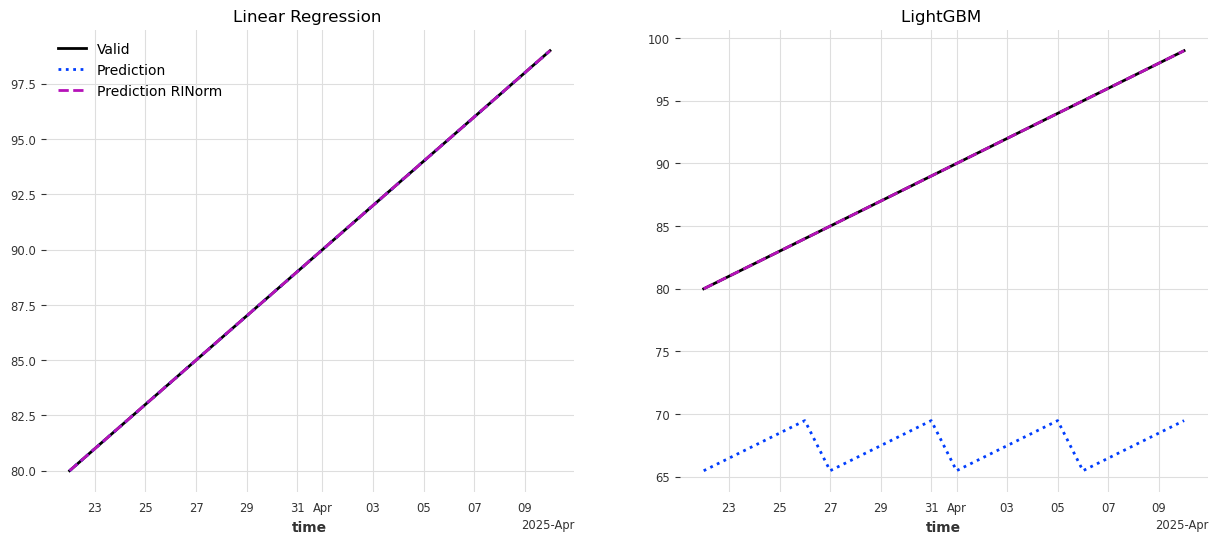

In [39]:
result_accumulator = evaluate_models(models_linear, linear_train, linear_val)

# Print the results nicely
for model_name, metrics in result_accumulator.items():
    print(f"Model: {model_name}")
    print(f"  MAE: {metrics['mae']:.3f}")
    print(f"  MSE: {metrics['mse']:.3f}\n")

In [40]:
backtest_errors_linear = backtest_models(models_linear, linear_train)

historical forecasts:   0%|          | 0/37 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/37 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/37 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/37 [00:00<?, ?it/s]

Average MAE: 0.000 for Linear Regression
Average MAE: 17.180 for LightGBM
Average MAE: 0.000 for Linear Regression RINorm
Average MAE: 0.000 for LightGBM RINorm


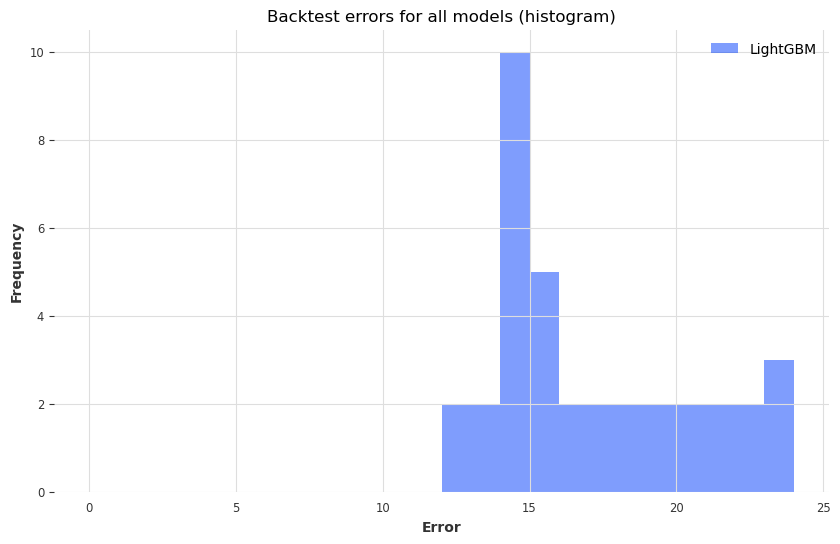

In [41]:
plot_backtest_results(backtest_errors_linear)

In this toy example, we see that RINorm helps LightGBM to extrapolate to values unseen during training. Let's explore how the performance of the models evolves when we use more complex datasets.

## Air Passenger and Milk

<Axes: xlabel='Month'>

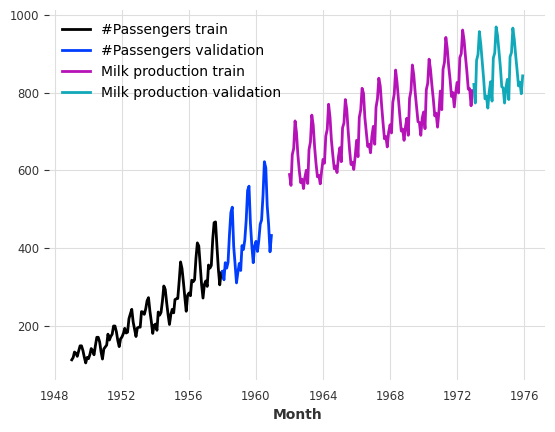

In [42]:
from darts.datasets import AirPassengersDataset, MonthlyMilkDataset

series_air = AirPassengersDataset().load().astype(np.float32)
series_milk = MonthlyMilkDataset().load().astype(np.float32)

# set aside last 36 months of each series as validation set:
train_air, val_air = series_air[:-36], series_air[-36:]
train_milk, val_milk = series_milk[:-36], series_milk[-36:]

train_air.plot(label="#Passengers train")
val_air.plot(label="#Passengers validation")
train_milk.plot(label="Milk production train")
val_milk.plot(label="Milk production validation")

In [43]:
# DEFINE PARAMETERS
LAGS = 40
OUTPUT_CHUNK_LENGTH = 5

# Define models
models_air_milk = {
    "Linear Regression": LinearRegressionModel(
        lags=LAGS, output_chunk_length=OUTPUT_CHUNK_LENGTH
    ),
    "LightGBM": LightGBMModel(lags=LAGS, output_chunk_length=OUTPUT_CHUNK_LENGTH),
    "Linear Regression RINorm": LinearRegressionModel(
        lags=LAGS,
        output_chunk_length=OUTPUT_CHUNK_LENGTH,
        use_reversible_instance_norm=True,
    ),
    "LightGBM RINorm": LightGBMModel(
        lags=LAGS,
        output_chunk_length=OUTPUT_CHUNK_LENGTH,
        use_reversible_instance_norm=True,
    ),
}

# Fit model to data
trains = [train_air, train_milk]
vals = [val_air, val_milk]

for i, (name, model) in enumerate(models_air_milk.items()):
    if "RINorm" not in name:
        with contextlib.redirect_stdout(open(os.devnull, "w")):
            model.fit(series=trains)

        rinorm_model = models_air_milk[name + " RINorm"]
        with contextlib.redirect_stdout(open(os.devnull, "w")):
            rinorm_model.fit(series=trains)

Model: Linear Regression
  MAE: ['18.846', '35.055']
  MSE: ['553.828', '1481.121']

Model: LightGBM
  MAE: ['53.039', '55.465']
  MSE: ['3870.858', '4356.913']

Model: Linear Regression RINorm
  MAE: ['30.220', '59.744']
  MSE: ['1057.880', '3996.704']

Model: LightGBM RINorm
  MAE: ['48.171', '57.409']
  MSE: ['2818.126', '3824.294']



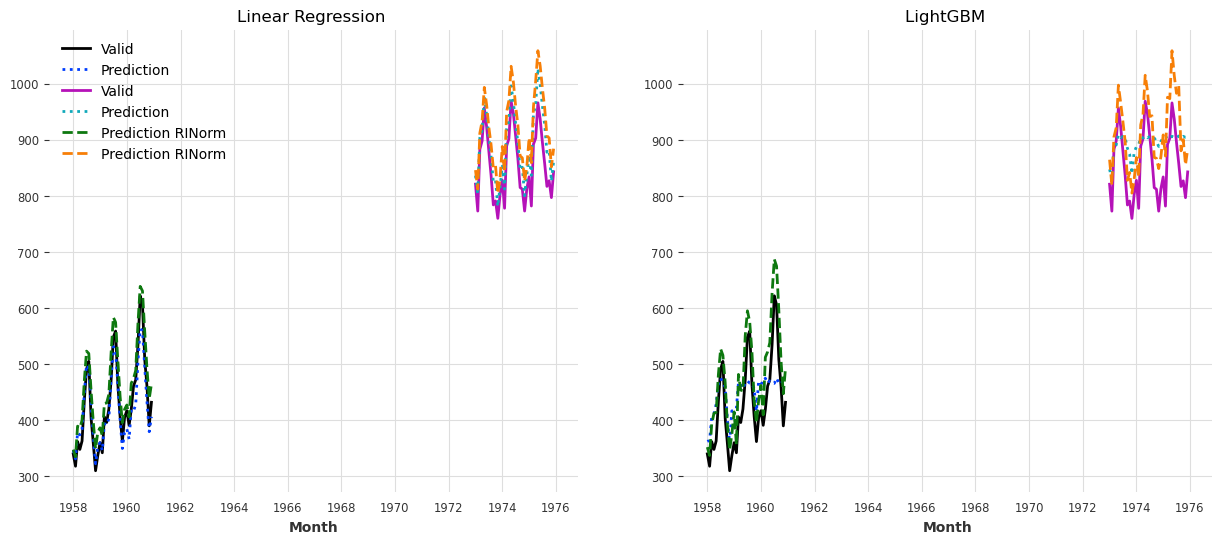

In [44]:
result_accumulator = evaluate_models(models_air_milk, trains, vals)

# Print the results nicely
for model_name, metrics in result_accumulator.items():
    print(f"Model: {model_name}")
    MAE_formatted = [f"{mae:.3f}" for mae in metrics["mae"]]
    MSE_formatted = [f"{mse:.3f}" for mse in metrics["mse"]]
    print(f"  MAE: {MAE_formatted}")
    print(f"  MSE: {MSE_formatted}\n")

In [45]:
backtest_errors_air_milk = backtest_models(models_air_milk, trains)

historical forecasts:   0%|          | 0/2 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/2 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/2 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/2 [00:00<?, ?it/s]

Average MAE: 52.901 for Linear Regression
Average MAE: 41.647 for LightGBM
Average MAE: 37.490 for Linear Regression RINorm
Average MAE: 28.048 for LightGBM RINorm


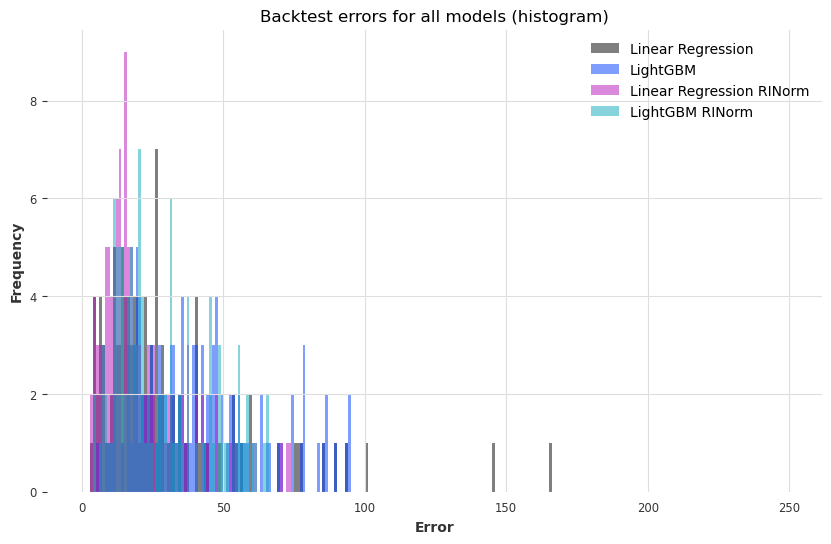

In [46]:
plot_backtest_results(backtest_errors_air_milk)

## Electricity Dataset

Text(0.5, 0, 'Hour')

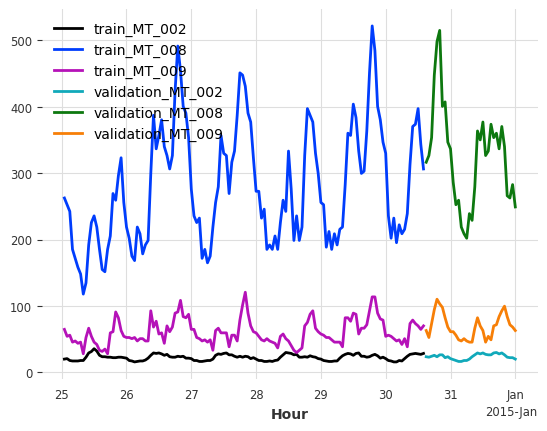

In [47]:
from darts.datasets import ElectricityDataset

multi_serie_elec = ElectricityDataset().load().astype(np.float32)
# retaining only three components in different ranges
retained_components = ["MT_002", "MT_008", "MT_009"]
multi_serie_elec = multi_serie_elec[retained_components]
# resampling the multivariate time serie
multi_serie_elec = multi_serie_elec.resample(freq="H")
# keep the values for the last 5 days
multi_serie_elec = multi_serie_elec[-168:]

train_elec, val_elec = multi_serie_elec.split_after(0.8)

train_elec.plot(label="train")
val_elec.plot(label="validation")
plt.xlabel("Hour")

In [48]:
LAGS = 40
OUTPUT_CHUNK_LENGTH = 5

# Define models
models_elec = {
    "Linear Regression": LinearRegressionModel(
        lags=LAGS, output_chunk_length=OUTPUT_CHUNK_LENGTH
    ),
    "LightGBM": LightGBMModel(lags=LAGS, output_chunk_length=OUTPUT_CHUNK_LENGTH),
    "Linear Regression RINorm": LinearRegressionModel(
        lags=LAGS,
        output_chunk_length=OUTPUT_CHUNK_LENGTH,
        use_reversible_instance_norm=True,
    ),
    "LightGBM RINorm": LightGBMModel(
        lags=LAGS,
        output_chunk_length=OUTPUT_CHUNK_LENGTH,
        use_reversible_instance_norm=True,
    ),
}

# Fit model to data
for i, (name, model) in enumerate(models_elec.items()):
    if "RINorm" not in name:
        with contextlib.redirect_stdout(open(os.devnull, "w")):
            model.fit(series=train_elec)

        rinorm_model = models_elec[name + " RINorm"]
        with contextlib.redirect_stdout(open(os.devnull, "w")):
            rinorm_model.fit(series=train_elec)

Model: Linear Regression
  MAE: 49.985
  MSE: 7932.027

Model: LightGBM
  MAE: 16.218
  MSE: 816.965

Model: Linear Regression RINorm
  MAE: 25.854
  MSE: 1820.614

Model: LightGBM RINorm
  MAE: 18.572
  MSE: 1137.978



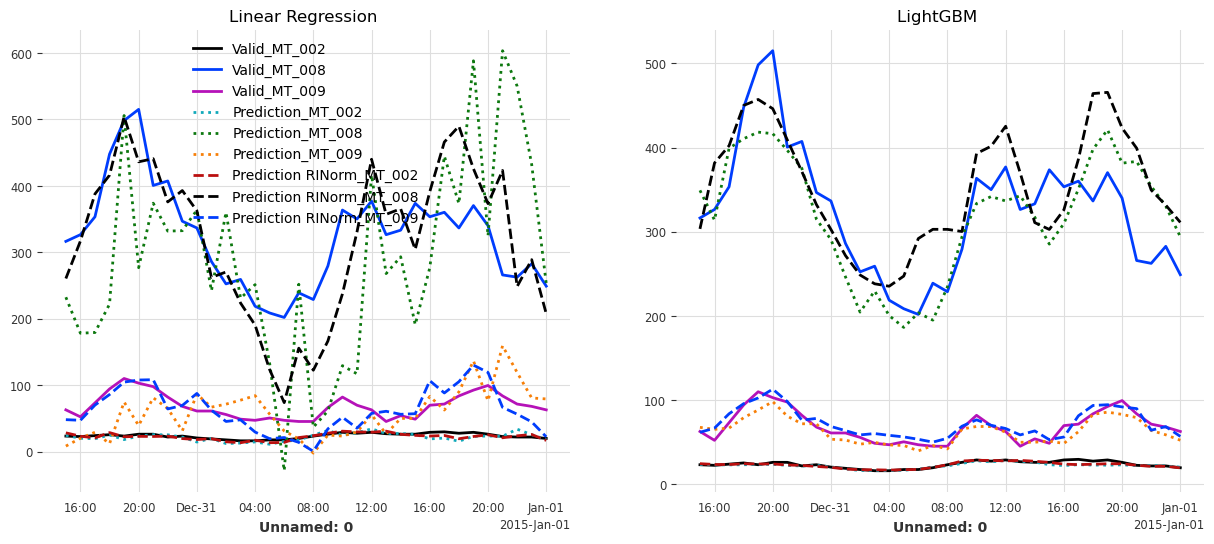

In [49]:
result_accumulator = evaluate_models(models_elec, train_elec, val_elec)

# Print the results nicely
for model_name, metrics in result_accumulator.items():
    print(f"Model: {model_name}")
    print(f"  MAE: {metrics['mae']:.3f}")
    print(f"  MSE: {metrics['mse']:.3f}\n")

In [50]:
backtest_errors_elec = backtest_models(models_elec, train_elec)

historical forecasts:   0%|          | 0/64 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/64 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/64 [00:00<?, ?it/s]

historical forecasts:   0%|          | 0/64 [00:00<?, ?it/s]

Average MAE: 32.588 for Linear Regression
Average MAE: 24.686 for LightGBM
Average MAE: 29.611 for Linear Regression RINorm
Average MAE: 26.830 for LightGBM RINorm


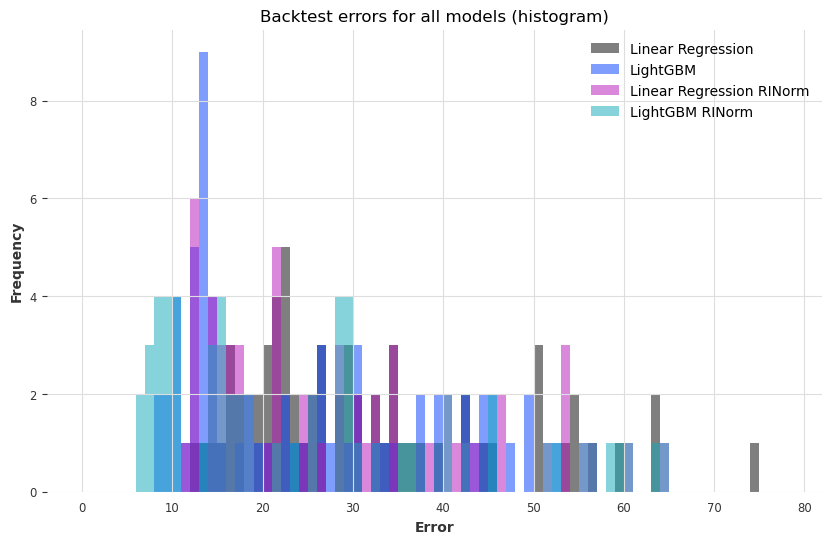

In [51]:
plot_backtest_results(backtest_errors_elec)

## Conclusion

Throughout these examples, we saw that RINorm does not improve drastically the performance of the models. Critically, the size of the lags window is critical for the performance of RINorm, if the window is too small, the models may become unstable as the mean and variance estimates are unaccurate.
However, it seems that RINorm may help tree based models to extrapolate to values unseen during training. This could be explored further in future experiments.